In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
plt.style.use("fivethirtyeight")

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from stochastic_rnn import StochasticLSTM
from stochastic_module import StochasticSingleOutputModule
from classification_uncertainty_utils import aleatoric_uncertainty, epistemic_uncertainty, prediction_avg, uncertainty_avg
from train_utils import weight_coefficient, bias_coefficient, filter_parameters, train_model

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import robust_scale

In [4]:
np.random.seed(1234)
torch.manual_seed(1234)

In [5]:
training_table = pd.read_csv("./data/occupancy_data/datatraining.txt")

In [6]:
# training_table["year"] = training_table["date"].str[:4].astype(int) # only 2015
# training_table["month"] = training_table["date"].str[5:7].astype(int) # only February
training_table["day"] = training_table["date"].str[8:10].astype(int)
training_table["hour"] = training_table["date"].str[11:13].astype(int)

In [7]:
training_table = training_table.drop("date", axis=1)

In [8]:
training_table.head(10)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour
1,23.180,27.2720,426.0,721.250000,0.004793,1,4,17
2,23.150,27.2675,429.5,714.000000,0.004783,1,4,17
3,23.150,27.2450,426.0,713.500000,0.004779,1,4,17
4,23.150,27.2000,426.0,708.250000,0.004772,1,4,17
5,23.100,27.2000,426.0,704.500000,0.004757,1,4,17
6,23.100,27.2000,419.0,701.000000,0.004757,1,4,17
7,23.100,27.2000,419.0,701.666667,0.004757,1,4,17
8,23.100,27.2000,419.0,699.000000,0.004757,1,4,17
9,23.100,27.2000,419.0,689.333333,0.004757,1,4,17
10,23.075,27.1750,419.0,688.000000,0.004745,1,4,18


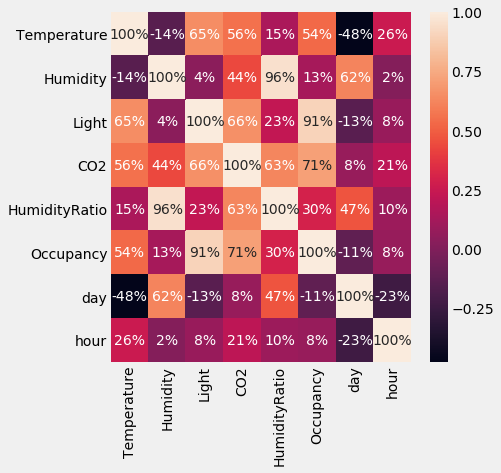

In [9]:
plt.subplots(figsize=(6, 6))
sns.heatmap(training_table.corr(), annot=True, fmt=".0%")

In [10]:
SEQ_LEN = 5
NUM_FEAT = 7
DROP = 0.5
ls = 1e-2
tau = 1

In [11]:
X_train = robust_scale(training_table.drop("Occupancy", axis=1).values)
Y_train = training_table["Occupancy"].values
training_sequence = [
    (X_train[i:i+SEQ_LEN, :], Y_train[i+SEQ_LEN]) for i in range(0, len(X_train) - SEQ_LEN)
]
N = len(Y_train)

In [12]:
dataloader = torch.utils.data.DataLoader(training_sequence, batch_size=40, shuffle=True)

In [13]:
class Net(StochasticSingleOutputModule):
    def __init__(self):
        super(Net, self).__init__(sample_size=10)
        self.rnn = StochasticLSTM(NUM_FEAT, 50, dropout_rate=DROP)
        #self.fc1 = nn.Linear(50*SEQ_LEN, 25)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
    
    def forward(self, x):
        result, _ = self.rnn(x)
        #result = result.transpose(-2,-3).flatten(-2)
        result = result[-1]
        result = torch.relu(self.fc1(result))
        result = self.fc2(result)
        return result

In [14]:
net = Net().double()
criterion = nn.BCEWithLogitsLoss()

M = filter_parameters(net.named_parameters(), "rnn", "weight")
m = filter_parameters(net.named_parameters(), "rnn", "bias")
other_params = filter_parameters(net.named_parameters(), "fc", "")

parameters = [
    {"params": M, "weight_decay": weight_coefficient(ls, tau, DROP, N)}, # dropout rnn weight
    {"params": m, "weight_decay": bias_coefficient(ls, tau, N)}, # dropout rnn bias
    {"params": other_params} # other parameters
]
optimizer = optim.Adam(parameters, lr=1e-3)

In [15]:
train_model(net, dataloader, criterion, optimizer, 10)

[1, 100.00%] loss: 0.337117
[2, 100.00%] loss: 0.153003
[3, 100.00%] loss: 0.138653
[4, 100.00%] loss: 0.124174
[5, 100.00%] loss: 0.110511
[6, 100.00%] loss: 0.110520
[7, 100.00%] loss: 0.106006
[8, 100.00%] loss: 0.090970
[9, 100.00%] loss: 0.099942
[10, 100.00%] loss: 0.096347
Finish training


## Test

In [16]:
testing_table = pd.read_csv("./data/occupancy_data/datatest2.txt")
testing_table["day"] = testing_table["date"].str[8:10].astype(int)
testing_table["hour"] = testing_table["date"].str[11:13].astype(int)
testing_table = testing_table.drop("date", axis=1)

In [17]:
X_test = robust_scale(testing_table.drop("Occupancy", axis=1).values)
X_test = np.array([X_test[i:i+SEQ_LEN, :] for i in range(0, len(X_test) - SEQ_LEN)])
X_test = X_test.swapaxes(1, 0)
Y_test = testing_table["Occupancy"].values[SEQ_LEN:]
X_test = torch.tensor(X_test)

In [18]:
net.eval()
with torch.no_grad():
    outputs = net(X_test)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.flatten(1)
    uncertainties = uncertainty_avg(outputs)
    predictions = prediction_avg(outputs)

In [19]:
roc_auc_score(Y_test, predictions)

0.9826159935146116

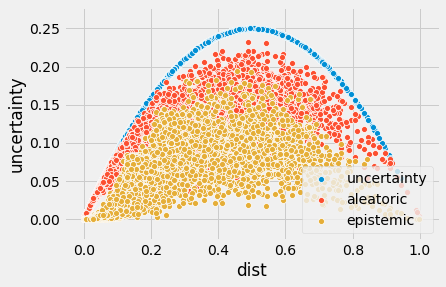

In [20]:
dist = torch.abs(predictions - Y_test)
A = aleatoric_uncertainty(outputs)
E = epistemic_uncertainty(outputs)

sns.scatterplot(x=dist, y=uncertainties)
sns.scatterplot(x=dist, y=A)
sns.scatterplot(x=dist, y=E)
plt.xlabel("dist")
plt.ylabel("uncertainty")
plt.legend(labels=['uncertainty', 'aleatoric', 'epistemic'])

### Spread analysis for misclassification

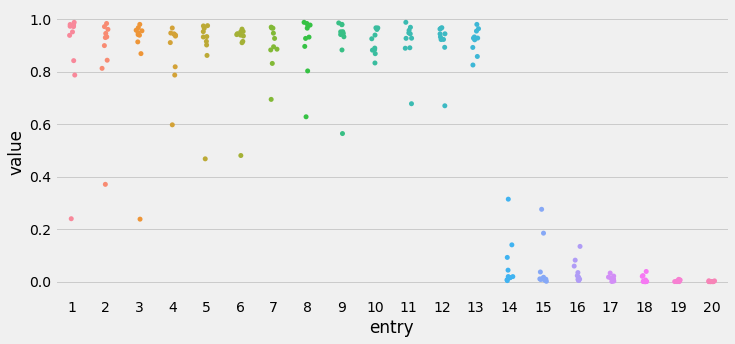

In [22]:
T, B = outputs.shape[0:2]
post_sigmoid_df = pd.DataFrame(columns=["entry","value"])
for i in range(T):
    for j, idx in enumerate(dist.argsort()[-20:]):
        post_sigmoid_df.loc[i*B + j] = (j+1, outputs[i,idx])

plot = sns.catplot(x="entry", y="value", data=post_sigmoid_df)
plot.fig.set_figwidth(12)

### Spread analysis for correct classification

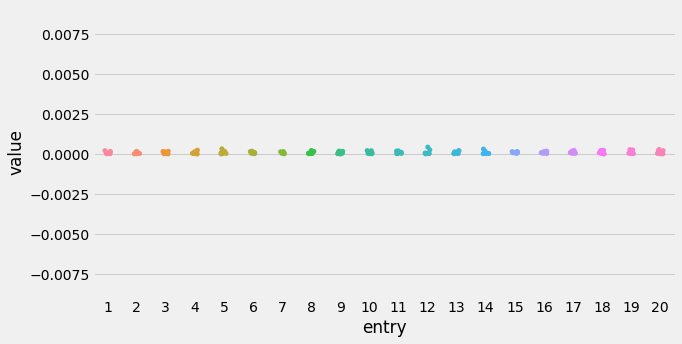

In [23]:
T, B = outputs.shape[0:2]
post_sigmoid_df = pd.DataFrame(columns=["entry","value"])
for i in range(T):
    for j, idx in enumerate(dist.argsort()[:20]):
        post_sigmoid_df.loc[i*B + j] = (j+1, outputs[i,idx])

plot = sns.catplot(x="entry", y="value", data=post_sigmoid_df)
plot.fig.set_figwidth(12)